In [1]:
!pip install -qq transformers
!pip install -qq sentencepiece
!pip install -qq datasets


     |████████████████████████████████| 3.5 MB 5.3 MB/s 
     |████████████████████████████████| 67 kB 3.5 MB/s 
     |████████████████████████████████| 895 kB 63.4 MB/s 
     |████████████████████████████████| 6.8 MB 71.3 MB/s 
     |████████████████████████████████| 596 kB 77.0 MB/s 
     |████████████████████████████████| 1.2 MB 5.3 MB/s 
     |████████████████████████████████| 311 kB 5.3 MB/s 
     |████████████████████████████████| 1.1 MB 77.0 MB/s 
     |████████████████████████████████| 133 kB 83.7 MB/s 
     |████████████████████████████████| 243 kB 85.7 MB/s 
     |████████████████████████████████| 144 kB 80.4 MB/s 
     |████████████████████████████████| 271 kB 81.1 MB/s 
     |████████████████████████████████| 94 kB 3.6 MB/s 


In [2]:
import transformers
import datasets
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, get_linear_schedule_with_warmup,Trainer, TrainingArguments
from transformers.file_utils import is_tf_available, is_torch_available, is_torch_tpu_available
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
import random
from textwrap import wrap
from datetime import datetime
from datasets import load_from_disk
from datasets import Dataset
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

In [ ]:
from torch import nn

In [ ]:
# the model we gonna train, base uncased BERT
# check text classification models here: https://huggingface.co/models?filter=text-classification
MODEL_NAME = "distilbert-base-uncased"
# max sequence length for each document/sentence sample
BATCH_SIZE = 16
EPOCHS = 3
LEARNING_RATE= 6.58e-5
#LEARNING_RATE= 3.5e-6
WEIGHT_DECAY = 0.129
WARMUP_STEPS = 164
RANDOM_SEED=22

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
def set_seed(seed):
    """Set all seeds to make results reproducible (deterministic mode).
       When seed is None, disables deterministic mode.
    :param seed: an integer to your choosing
    """
    if seed is not None:
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        np.random.seed(seed)
        random.seed(seed)

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  # calculate accuracy using sklearn's function
  acc = accuracy_score(labels, preds)
  precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
  acc = accuracy_score(labels, preds)
  confusion_matrix = classification_report(labels, preds, digits=4,output_dict=True)
  return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'hate_f1': confusion_matrix["0"]["f1-score"],
        'hate_recall': confusion_matrix["0"]["recall"],
        'hate_precision': confusion_matrix["0"]["precision"],
        'offensive_f1': confusion_matrix["1"]["f1-score"],
        'offensive_recall': confusion_matrix["1"]["recall"],
        'offensive_precision': confusion_matrix["1"]["precision"],
        'normal_f1': confusion_matrix["2"]["f1-score"],
        'normal_recall': confusion_matrix["2"]["recall"],
        'normal_precision': confusion_matrix["2"]["precision"],    
  }


def model_init():
  temp_model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME,num_labels=3).to(device)
  return temp_model

# Code modified from Stabilizer library to handle DistilBERT architecture
#https://github.com/flowerpot-ai/stabilizer


def get_optimizer_parameters_with_llrd(model, peak_lr, multiplicative_factor):
    num_encoder_layers = len(model.distilbert.transformer.layer)
    # Task specific layer gets the peak_lr
    tsl_parameters = [
        {
            "params": [param for name, param in model.named_parameters() if 'distilbert' not in name],
            "param_names": [name for name, param in model.named_parameters() if 'distilbert' not in name],
            "lr": peak_lr,
            "name": "tsl",
        }
    ]

    # Starting from the last encoder layer each encoder layers get a lr defined by
    # current_layer_lr = prev_layer_lr * multiplicative_factor
    # the last encoder layer lr = peak_lr * multiplicative_factor
    encoder_parameters = [
        {
            "params": [param for name, param in model.named_parameters() if f"distilbert.transformer.layer.{layer_num}" in name],
            "param_names": [name for name, param in model.named_parameters() if f"distilbert.transformer.layer.{layer_num}" in name],
            "lr": peak_lr * (multiplicative_factor ** (num_encoder_layers - layer_num)),
            "name": f"layer_{layer_num}",
        }
        for layer_num, layer in enumerate(model.distilbert.transformer.layer)
    ]

    # Embedding layer gets embedding layer lr = first encoder layer lr * multiplicative_factor
    embedding_parameters = [
        {
            "params": [param for name, param in model.named_parameters() if 'embeddings' in name],
            "param_names": [name for name, param in model.named_parameters() if 'embeddings' in name],
            "lr": peak_lr * (multiplicative_factor ** (num_encoder_layers + 1)),
            "name": "embedding",
        }
    ]
    return tsl_parameters + encoder_parameters + embedding_parameters

def timestamp():
    dateTimeObj = datetime.now()
    timestampStr = dateTimeObj.strftime("%d-%b-%Y (%H:%M:%S.%f)")
    print(timestampStr)

In [ ]:
set_seed(RANDOM_SEED)


In [ ]:
result_list = []
for i in range(1,11):

  training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Dissertation/disbert_hate_llrd/results/'+str(i),          # output directory
    num_train_epochs=EPOCHS,              # total number of training epochs
    save_strategy ="epoch" ,
    per_device_train_batch_size=BATCH_SIZE,  # batch size per device during training
    per_device_eval_batch_size=BATCH_SIZE,   # batch size for evaluation
    weight_decay= WEIGHT_DECAY,               # strength of weight decay
    learning_rate= LEARNING_RATE, 
    warmup_steps = WARMUP_STEPS,
    logging_dir='./disbert_hate_llrd/logs',     # directory for storing logs
    load_best_model_at_end=True,     # load the best model when finished training (default metric is loss)
    evaluation_strategy="epoch",
  )

  hatetwit_dataset_dfs = load_from_disk('/content/drive/MyDrive/Dissertation/datasets/hatetwit_'+str(i))
  train_dataset = hatetwit_dataset_dfs ["train"].remove_columns(["input_ids_bert","attention_mask_bert","token_type_ids_bert"])
  eval_dataset = hatetwit_dataset_dfs ["validation"].remove_columns(["input_ids_bert","attention_mask_bert","token_type_ids_bert"])
  test_dataset = hatetwit_dataset_dfs ["test"].remove_columns(["input_ids_bert","attention_mask_bert","token_type_ids_bert"])
  model = model_init()
  parameters = get_optimizer_parameters_with_llrd(model, LEARNING_RATE, 0.95)
  trainer = Trainer(
      model=model,                         # the instantiated Transformers model to be trained
      args=training_args,                  # training arguments, defined above
      train_dataset= train_dataset,         # training dataset
      eval_dataset=eval_dataset,          # evaluation dataset
      compute_metrics=compute_metrics,     # the callback that computes metrics of interest
  )
  trainer.create_optimizer()
  trainer.optimizer = AdamW(parameters, lr=LEARNING_RATE,weight_decay=WEIGHT_DECAY)
  trainer.train()
  trainer.save_model('/content/drive/MyDrive/Dissertation/disbert_hate_llrd/models/model_'+str(i))
  results = trainer.evaluate(test_dataset)
  results["model_run"] = i
  result_list.append(results)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Hate F1,Hate Recall,Hate Precision,Offensive F1,Offensive Recall,Offensive Precision,Normal F1,Normal Recall,Normal Precision
1,0.562900,0.530089,0.782142,0.737673,0.735157,0.746929,0.720289,0.801811,0.653815,0.859360,0.840429,0.879163,0.633370,0.598548,0.672494
2,0.427000,0.478901,0.811548,0.764638,0.772563,0.759949,0.773242,0.790744,0.756497,0.881658,0.897816,0.866071,0.639013,0.591286,0.695122
3,0.278900,0.551580,0.809830,0.768845,0.765866,0.773092,0.786712,0.821932,0.754386,0.877612,0.870789,0.884543,0.642212,0.626556,0.658670


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 16
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_llrd/results/1/checkpoint-2330
Configuration saved in /content/drive/MyDrive/Dissertation/disbert_hate_llrd/results/1/checkpoint-2330/config.json
Model weights saved in /content/drive/MyDrive/Dissertation/disbert_hate_llrd/results/1/checkpoint-2330/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 16
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_llrd/results/1/checkpoint-4660
Configuration saved in /content/drive/MyDriv

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Hate F1,Hate Recall,Hate Precision,Offensive F1,Offensive Recall,Offensive Precision,Normal F1,Normal Recall,Normal Precision
1,0.562700,0.529708,0.793089,0.744394,0.751636,0.743245,0.731315,0.777666,0.690179,0.868305,0.876342,0.860414,0.633562,0.575726,0.704315
2,0.427400,0.515588,0.807469,0.767980,0.762275,0.781602,0.781908,0.878270,0.704600,0.874238,0.849315,0.900667,0.647795,0.617220,0.681558
3,0.259500,0.561834,0.816484,0.779233,0.775799,0.783495,0.801164,0.830986,0.773408,0.878641,0.871159,0.886252,0.657895,0.648340,0.667735


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 16
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_llrd/results/2/checkpoint-2330
Configuration saved in /content/drive/MyDrive/Dissertation/disbert_hate_llrd/results/2/checkpoint-2330/config.json
Model weights saved in /content/drive/MyDrive/Dissertation/disbert_hate_llrd/results/2/checkpoint-2330/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 16
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_llrd/results/2/checkpoint-4660
Configuration saved in /content/drive/MyDriv

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Hate F1,Hate Recall,Hate Precision,Offensive F1,Offensive Recall,Offensive Precision,Normal F1,Normal Recall,Normal Precision
1,0.556200,0.550140,0.776991,0.722388,0.736599,0.713914,0.711443,0.719316,0.703740,0.855605,0.883006,0.829854,0.600115,0.539419,0.676203
2,0.423300,0.506001,0.803177,0.753334,0.769038,0.746592,0.771470,0.799799,0.745080,0.871786,0.897445,0.847552,0.616745,0.542531,0.714481
3,0.266000,0.586377,0.804679,0.763226,0.765290,0.761347,0.788945,0.789738,0.788153,0.871436,0.877083,0.865863,0.629297,0.617220,0.641855


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 16
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_llrd/results/3/checkpoint-2330
Configuration saved in /content/drive/MyDrive/Dissertation/disbert_hate_llrd/results/3/checkpoint-2330/config.json
Model weights saved in /content/drive/MyDrive/Dissertation/disbert_hate_llrd/results/3/checkpoint-2330/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 16
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_llrd/results/3/checkpoint-4660
Configuration saved in /content/drive/MyDriv

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Hate F1,Hate Recall,Hate Precision,Offensive F1,Offensive Recall,Offensive Precision,Normal F1,Normal Recall,Normal Precision
1,0.565000,0.545790,0.781927,0.728146,0.751377,0.724864,0.726437,0.794769,0.668925,0.856265,0.876712,0.836749,0.601737,0.503112,0.748457
2,0.424100,0.527110,0.789011,0.751565,0.742404,0.767712,0.759425,0.851107,0.685575,0.856703,0.823399,0.892814,0.638567,0.628631,0.648822
3,0.277500,0.568358,0.806396,0.764175,0.764762,0.766979,0.788224,0.835010,0.746403,0.871852,0.871529,0.872175,0.632450,0.594398,0.675708


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 16
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_llrd/results/4/checkpoint-2330
Configuration saved in /content/drive/MyDrive/Dissertation/disbert_hate_llrd/results/4/checkpoint-2330/config.json
Model weights saved in /content/drive/MyDrive/Dissertation/disbert_hate_llrd/results/4/checkpoint-2330/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 16
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_llrd/results/4/checkpoint-4660
Configuration saved in /content/drive/MyDriv

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Hate F1,Hate Recall,Hate Precision,Offensive F1,Offensive Recall,Offensive Precision,Normal F1,Normal Recall,Normal Precision
1,0.550500,0.531634,0.783645,0.730830,0.750730,0.718309,0.712259,0.707243,0.717347,0.857854,0.893743,0.824735,0.622378,0.553942,0.710106
2,0.418400,0.486576,0.810260,0.767282,0.772743,0.762923,0.771772,0.775654,0.767928,0.877167,0.889670,0.865011,0.652906,0.623444,0.685291
3,0.265100,0.567558,0.812406,0.769892,0.771513,0.769351,0.791360,0.810865,0.772771,0.879396,0.884117,0.874725,0.638919,0.613071,0.667043


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 16
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_llrd/results/5/checkpoint-2330
Configuration saved in /content/drive/MyDrive/Dissertation/disbert_hate_llrd/results/5/checkpoint-2330/config.json
Model weights saved in /content/drive/MyDrive/Dissertation/disbert_hate_llrd/results/5/checkpoint-2330/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 16
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_llrd/results/5/checkpoint-4660
Configuration saved in /content/drive/MyDriv

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Hate F1,Hate Recall,Hate Precision,Offensive F1,Offensive Recall,Offensive Precision,Normal F1,Normal Recall,Normal Precision
1,0.564100,0.526468,0.782786,0.738570,0.743688,0.734070,0.728690,0.705231,0.753763,0.854948,0.865235,0.844902,0.632071,0.631743,0.632399
2,0.416400,0.492574,0.806611,0.767511,0.766816,0.769643,0.794388,0.825956,0.765144,0.868792,0.867827,0.869759,0.639353,0.615145,0.665544
3,0.249600,0.588790,0.810474,0.772104,0.767682,0.778156,0.798853,0.841046,0.760692,0.874110,0.863754,0.884717,0.643349,0.629668,0.657638


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 16
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_llrd/results/6/checkpoint-2330
Configuration saved in /content/drive/MyDrive/Dissertation/disbert_hate_llrd/results/6/checkpoint-2330/config.json
Model weights saved in /content/drive/MyDrive/Dissertation/disbert_hate_llrd/results/6/checkpoint-2330/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 16
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_llrd/results/6/checkpoint-4660
Configuration saved in /content/drive/MyDriv

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Hate F1,Hate Recall,Hate Precision,Offensive F1,Offensive Recall,Offensive Precision,Normal F1,Normal Recall,Normal Precision
1,0.560100,0.528842,0.789654,0.744095,0.749822,0.741566,0.743689,0.770624,0.718574,0.859546,0.870048,0.849295,0.629050,0.584025,0.681598
2,0.426500,0.488321,0.806825,0.764032,0.770578,0.760486,0.776908,0.798793,0.756190,0.871215,0.884117,0.858684,0.643973,0.598548,0.696860
3,0.268100,0.573359,0.811977,0.773104,0.772005,0.774653,0.793120,0.811871,0.775216,0.875742,0.874121,0.877369,0.650449,0.637967,0.663430


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 16
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_llrd/results/7/checkpoint-2330
Configuration saved in /content/drive/MyDrive/Dissertation/disbert_hate_llrd/results/7/checkpoint-2330/config.json
Model weights saved in /content/drive/MyDrive/Dissertation/disbert_hate_llrd/results/7/checkpoint-2330/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 16
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_llrd/results/7/checkpoint-4660
Configuration saved in /content/drive/MyDriv

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Hate F1,Hate Recall,Hate Precision,Offensive F1,Offensive Recall,Offensive Precision,Normal F1,Normal Recall,Normal Precision
1,0.561400,0.550100,0.783001,0.735305,0.740803,0.732740,0.735151,0.759557,0.712264,0.856151,0.867086,0.845487,0.614612,0.571577,0.664656
2,0.430700,0.526517,0.792445,0.745575,0.752692,0.739289,0.754892,0.737425,0.773207,0.865710,0.881896,0.850107,0.616124,0.598548,0.634763
3,0.275900,0.593492,0.805752,0.765202,0.763921,0.766912,0.787224,0.805835,0.769452,0.872356,0.870418,0.874303,0.636027,0.624481,0.648009


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 16
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_llrd/results/8/checkpoint-2330
Configuration saved in /content/drive/MyDrive/Dissertation/disbert_hate_llrd/results/8/checkpoint-2330/config.json
Model weights saved in /content/drive/MyDrive/Dissertation/disbert_hate_llrd/results/8/checkpoint-2330/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 16
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_llrd/results/8/checkpoint-4660
Configuration saved in /content/drive/MyDriv

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Hate F1,Hate Recall,Hate Precision,Offensive F1,Offensive Recall,Offensive Precision,Normal F1,Normal Recall,Normal Precision
1,0.566900,0.551633,0.783430,0.730578,0.752952,0.715323,0.707292,0.683099,0.733261,0.856992,0.898556,0.819102,0.627451,0.564315,0.706494
2,0.436200,0.509417,0.805108,0.761952,0.767719,0.761152,0.767619,0.810865,0.728752,0.870778,0.878193,0.863487,0.647458,0.594398,0.710918
3,0.279100,0.590794,0.803177,0.764428,0.762631,0.766306,0.782565,0.785714,0.779441,0.869695,0.864865,0.874579,0.641026,0.648340,0.633874


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 16
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_llrd/results/9/checkpoint-2330
Configuration saved in /content/drive/MyDrive/Dissertation/disbert_hate_llrd/results/9/checkpoint-2330/config.json
Model weights saved in /content/drive/MyDrive/Dissertation/disbert_hate_llrd/results/9/checkpoint-2330/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 16
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_llrd/results/9/checkpoint-4660
Configuration saved in /content/drive/MyDriv

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Hate F1,Hate Recall,Hate Precision,Offensive F1,Offensive Recall,Offensive Precision,Normal F1,Normal Recall,Normal Precision
1,0.567300,0.530137,0.789225,0.732465,0.757529,0.717484,0.723361,0.710262,0.736952,0.865493,0.910033,0.825109,0.608541,0.532158,0.710526
2,0.442600,0.505552,0.804250,0.756708,0.766264,0.750243,0.756219,0.764588,0.748031,0.875249,0.894854,0.856485,0.638655,0.591286,0.694275
3,0.277200,0.563636,0.808328,0.766561,0.767950,0.765360,0.772000,0.776660,0.767396,0.876520,0.880415,0.872661,0.651163,0.639004,0.663793


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 16
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_llrd/results/10/checkpoint-2330
Configuration saved in /content/drive/MyDrive/Dissertation/disbert_hate_llrd/results/10/checkpoint-2330/config.json
Model weights saved in /content/drive/MyDrive/Dissertation/disbert_hate_llrd/results/10/checkpoint-2330/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 16
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_llrd/results/10/checkpoint-4660
Configuration saved in /content/drive/My

In [ ]:
timestamp()

14-Feb-2022 (23:01:49.164785)


In [ ]:
results_df = pd.DataFrame(result_list)
results_df.to_csv('/content/drive/MyDrive/Dissertation/results/distilbert_llrd.csv')

In [ ]:
#Sort rows to determine the mix, max and median 
results_df = results_df.sort_values(by=['eval_f1'])
#Print min values
results_df.head(1)

,eval_loss,eval_accuracy,eval_f1,eval_precision,eval_recall,eval_hate_f1,eval_hate_recall,eval_hate_precision,eval_offensive_f1,eval_offensive_recall,eval_offensive_precision,eval_normal_f1,eval_normal_recall,eval_normal_precision,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch,model_run
5,0.50151,0.800773,0.753821,0.758464,0.751334,0.777778,0.796576,0.759846,0.87187,0.883333,0.8607,0.611817,0.574093,0.654846,4.5414,1025.672,64.297,3.0,6


In [ ]:
#Print max values 
results_df.tail(1)

,eval_loss,eval_accuracy,eval_f1,eval_precision,eval_recall,eval_hate_f1,eval_hate_recall,eval_hate_precision,eval_offensive_f1,eval_offensive_recall,eval_offensive_precision,eval_normal_f1,eval_normal_recall,eval_normal_precision,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch,model_run
1,0.519406,0.805067,0.766486,0.761343,0.778609,0.782098,0.871098,0.709598,0.869565,0.848148,0.892092,0.647795,0.61658,0.682339,3.9435,1181.179,74.046,3.0,2


In [ ]:
#Print median f1
results_df["eval_f1"].median()

0.7596179455147313

In [ ]:
#Print average values
results_df.mean()

eval_loss                      0.508580
eval_accuracy                  0.803306
eval_f1                        0.759532
eval_precision                 0.763414
eval_recall                    0.759900
eval_hate_f1                   0.774456
eval_hate_recall               0.809668
eval_hate_precision            0.744097
eval_offensive_f1              0.871012
eval_offensive_recall          0.875630
eval_offensive_precision       0.867226
eval_normal_f1                 0.633129
eval_normal_recall             0.594404
eval_normal_precision          0.678919
eval_runtime                   4.277420
eval_samples_per_second     1097.497400
eval_steps_per_second         68.799800
epoch                          3.000000
model_run                      5.500000
dtype: float64

In [ ]:
results_df.std()

eval_loss                     0.008435
eval_accuracy                 0.003864
eval_f1                       0.004274
eval_precision                0.006943
eval_recall                   0.010613
eval_hate_f1                  0.007287
eval_hate_recall              0.033044
eval_hate_precision           0.028622
eval_offensive_f1             0.003675
eval_offensive_recall         0.021946
eval_offensive_precision      0.017515
eval_normal_f1                0.014692
eval_normal_recall            0.030047
eval_normal_precision         0.022331
eval_runtime                  0.399662
eval_samples_per_second     101.472003
eval_steps_per_second         6.361026
epoch                         0.000000
model_run                     3.027650
dtype: float64

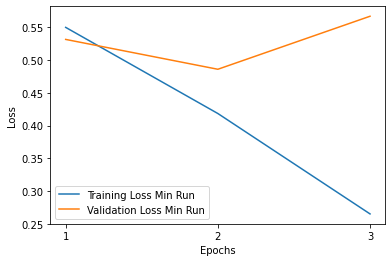

In [3]:
training_loss_min = [0.55,0.4184,0.265]
training_loss_max = [0.5629,0.4270,0.2789]
val_loss_min = [0.5316,0.486,0.567]
val_loss_max = [0.5300,0.478901,0.551580]
epoch_list=[1,2,3]

plt.figure()
plt.plot(epoch_list,training_loss_min, label="Training Loss Min Run")
plt.plot(epoch_list,val_loss_min, label="Validation Loss Min Run")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(epoch_list)
plt.legend()
plt.show()

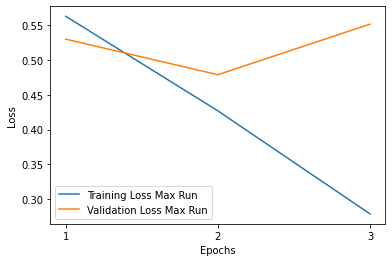

In [4]:
plt.figure()
plt.plot(epoch_list,training_loss_max, label="Training Loss Max Run")
plt.plot(epoch_list,val_loss_max, label="Validation Loss Max Run")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(epoch_list)
plt.legend()
plt.show()

6.58e-5
eval_loss                      0.508580
eval_accuracy                  0.803306
eval_f1                        0.759532
eval_precision                 0.763414
eval_recall                    0.759900
eval_hate_f1                   0.774456
eval_hate_recall               0.809668
eval_hate_precision            0.744097
eval_offensive_f1              0.871012
eval_offensive_recall          0.875630
eval_offensive_precision       0.867226
eval_normal_f1                 0.633129
eval_normal_recall             0.594404
eval_normal_precision          0.678919
eval_runtime                   4.292950
eval_samples_per_second     1091.155200
eval_steps_per_second         68.402300
epoch                          3.000000
model_run                      5.500000
dtype: float64

In [ ]:
#Print average values
results_df.mean()

eval_loss                      0.508580
eval_accuracy                  0.803306
eval_f1                        0.759532
eval_precision                 0.763414
eval_recall                    0.759900
eval_hate_f1                   0.774456
eval_hate_recall               0.809668
eval_hate_precision            0.744097
eval_offensive_f1              0.871012
eval_offensive_recall          0.875630
eval_offensive_precision       0.867226
eval_normal_f1                 0.633129
eval_normal_recall             0.594404
eval_normal_precision          0.678919
eval_runtime                   4.277420
eval_samples_per_second     1097.497400
eval_steps_per_second         68.799800
epoch                          3.000000
model_run                      5.500000
dtype: float64